In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os, time

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

# Cycle GAN Tensorflow 2.0 Example

Code copied from https://www.tensorflow.org/tutorials/generative/cyclegan

In [3]:
latent_dim = 100 #@param {type:"slider", min:0, max:100, step:100}

BATCH_SIZE = 1 #@param ["32", "64", "128", "256", "512", "1024", "1"] {type:"raw"}

BUFFER_SIZE = 3000 #@param {type:"slider", min:0, max:60000, step:1000}

IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                                             with_info = True, as_supervised=True)

train_monet, train_photos = dataset['trainA'], dataset['trainB']
test_monet, test_photos = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteWHN4V1/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteWHN4V1/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteWHN4V1/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteWHN4V1/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


## Showing off Image Processing

In [5]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [6]:
train_photos = train_photos.map(
    preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_monet = train_monet.map(
    preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_photos = test_photos.map(
    preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_monet = test_monet.map(
    preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [7]:
sample_photo = next(iter(train_photos))
sample_monet = next(iter(train_monet))

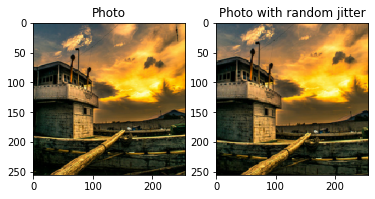

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

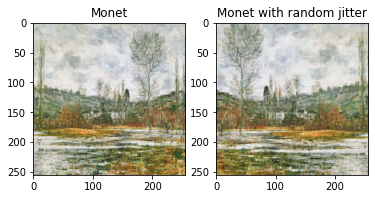

In [9]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

# Define Generator and Discriminator

In [10]:
from tensorflow_examples.models.pix2pix import pix2pix

OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [11]:
generator_g.summary()
discriminator_x.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 6 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 1 131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 2 524800      sequential_1[0][0]               
_______________________________________________________________________________________

#### Test out pre built generators

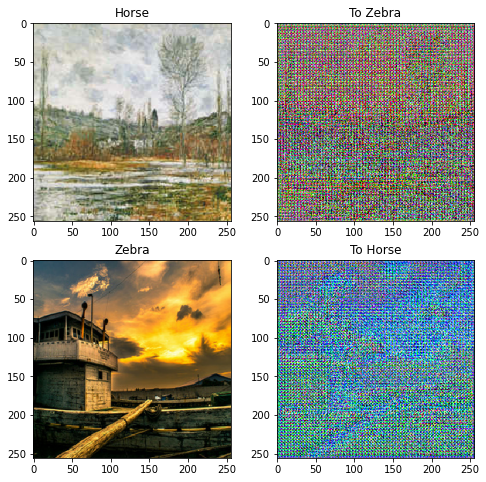

In [12]:
to_monet = generator_g(sample_monet)
to_photo = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_monet, to_monet, sample_photo, to_photo]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

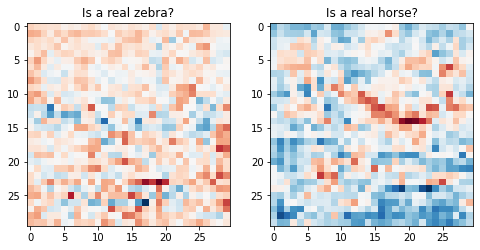

In [13]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss Functions

In [14]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

## Define Optimizers

In [15]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define Training

#### Helper Functions

In [16]:
def generate_images(model, test_input):
  prediction = model(test_input)
  plt.figure(figsize=(12, 12))
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

#### Train Step

In [17]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:

    
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [24]:
def progress_bar(step, total = 1072):
  progress = int(step/total * 100)
  print("\r|{}{}|{}%".format(progress * "*", (100-progress)  * " ", progress), end="") 

def train_cycle_gan(EPOCHS):
  example_monet = test_monet.take(5)
  example_photo = test_photos.take(5)

  for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    
    for image_x, image_y in tf.data.Dataset.zip((train_monet, train_photos)):
      train_step(image_x, image_y)
      progress_bar(n)
      n+=1
      
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_monet)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

    if epoch % 5 == 0:
      save_models = True
      if save_models:
        generator_f.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/F_Generator')
        generator_g.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/G_Generator')
        discriminator_x.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/X_Discriminator')
        discriminator_y.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/Y_Discriminator')

In [19]:
load_models = False
if load_models:
  generator_f = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/F_Generator')
  generator_g = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/G_Generator')
  discriminator_x = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/X_Discriminator')
  discriminator_y = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/Y_Discriminator')

In [25]:
train_cycle_gan(20)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
save_models = False
if save_models:
  generator_f.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/F_Generator')
  generator_g.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/G_Generator')
  discriminator_x.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/X_Discriminator')
  discriminator_y.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/Y_Discriminator')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/F_Generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/G_Generator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/X_Discriminator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/GANS/Saved Models/First_Cycle_GAN_Models/Y_Discriminator/assets


In [26]:
# Run the trained model on the test dataset
for inp in test_monet.take(5):
  generate_images(generator_g, inp)

Output hidden; open in https://colab.research.google.com to view.

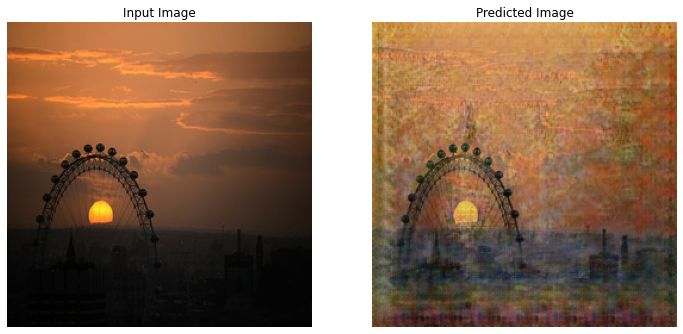

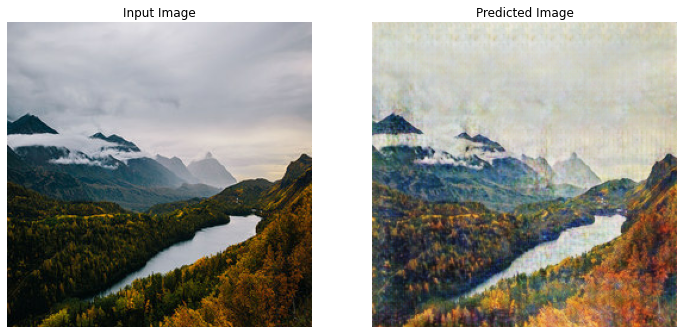

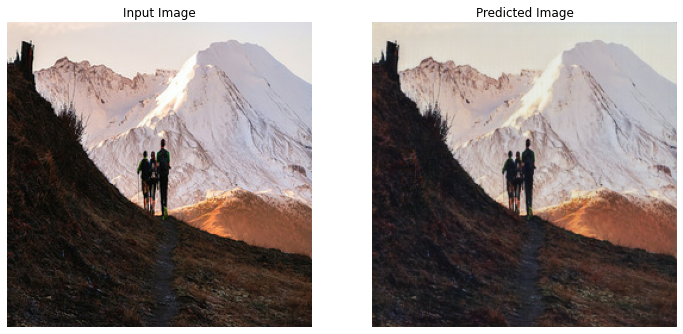

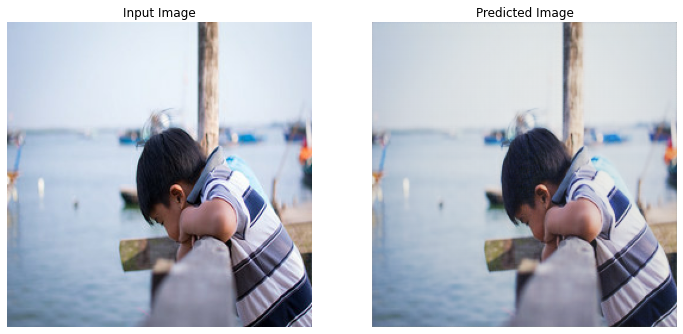

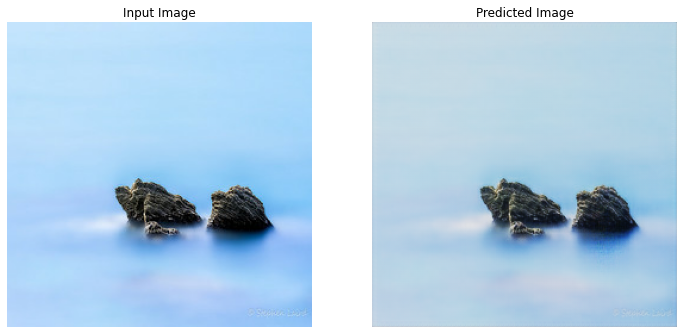

In [27]:
# Run the trained model on the test dataset
for inp in test_photos.take(5):
  generate_images(generator_f, inp)

## Test

In [28]:
generator_g.save('/content/test')

INFO:tensorflow:Assets written to: /content/test/assets


INFO:tensorflow:Assets written to: /content/test/assets


In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/test')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quantized_model)

159130768